Affective workflow!!

In [1]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task


In [2]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from affective_computing.get_pipe_data import get_pipe_data
import cv2
import keras
import tensorflow as tf
from pygame import Rect, Vector2
import numpy as np
import matplotlib.pyplot as plt
from affective_computing.point_cloud import FaceCloud
from joblib import dump, load

pygame 2.5.2 (SDL 2.28.3, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
im_path = "sample_images/anger-01.png"
# im_path = "Affective_Computing/Sample_Images/Ben Glasses.png"

# get image as RGB array
img_array = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2RGB)
# get image as mediapipe image
img_mp = mp.Image(data=img_array, image_format=mp.ImageFormat.SRGB)

Initialise mediapipe face detector and process loaded image

In [4]:
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options, output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True, num_faces=1, )
detector = vision.FaceLandmarker.create_from_options(options)
face_landmarks, blend_data, _ = get_pipe_data(detector, img_mp)

base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')

I0000 00:00:1709711328.473333       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Max
W0000 00:00:1709711328.473646       1 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## Image Segmentation
crop face region from image

In [5]:
def segment_face(landmarks, img_array):
    px_locations_x = landmarks[:, 0] * img_array.shape[1]
    px_locations_y = landmarks[:, 1] * img_array.shape[0]
    
    max_x, min_x = max(px_locations_x), min(px_locations_x)
    max_y, min_y = max(px_locations_y), min(px_locations_y)
    
    # create bounding box of face and scale to adjust for full head region
    scale = Vector2(1.8, 1.6)
    bbox = np.asarray([min_x, min_y, max_x-min_x, max_y-min_y], dtype=np.int16)
    face_rect = Rect(bbox).scale_by(scale.x, scale.y)
    face_rect = face_rect.clip(Rect((0, 0), img_array.shape[:2]))
    cropped_img = img_array[face_rect.top:face_rect.bottom, face_rect.left:face_rect.right]
    
    return cropped_img

Segment and resize image for input to InceptionResNetV2

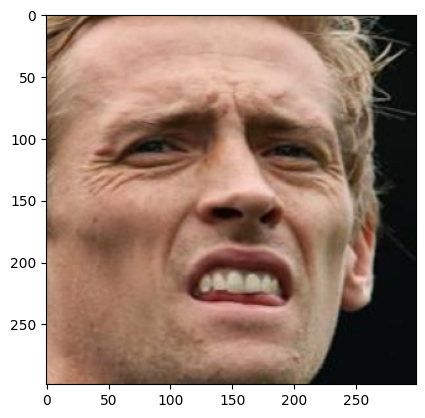

In [6]:
img_face = segment_face(face_landmarks, img_array)
img_face = cv2.resize(img_face, (299, 299))
plt.imshow(img_face)
plt.show()

In [7]:
model = keras.models.load_model('../models/AffectInceptionResNetV3.keras')
image_shape = (224, 224, 3)
class_names = ["Negative", "Neutral", "Positive"]
img = keras.utils.load_img(im_path, target_size=image_shape[:2])

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

/Users/benhoskings/Documents/Pycharm/Hero_Monitor/venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:394: UserWarning: Skipping variable loading for optimizer 'adam', because it has 354 variables whereas the saved optimizer has 28 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
This image most likely belongs to Negative with a 100.00 percent confidence.


Create the shape feature from 3D landmark locations

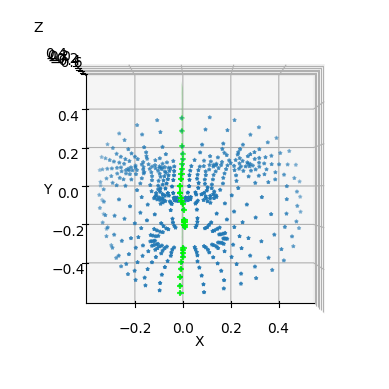

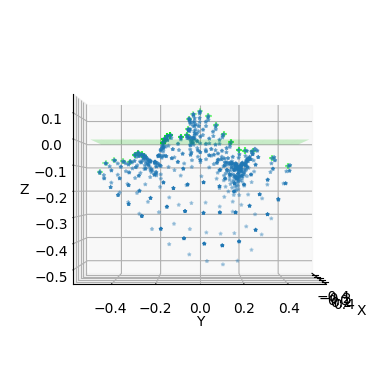

In [8]:
face = FaceCloud(face_landmarks)
face.preprocess(scale=True, demo=True)

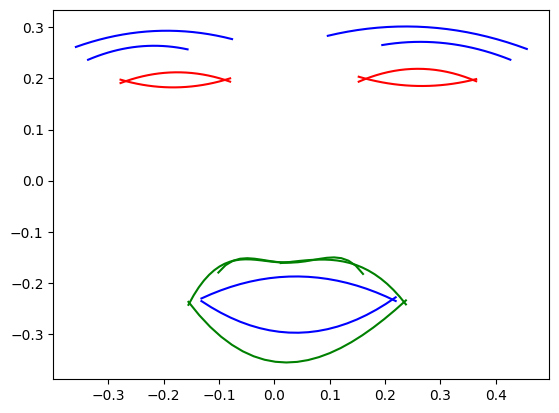

(49,)


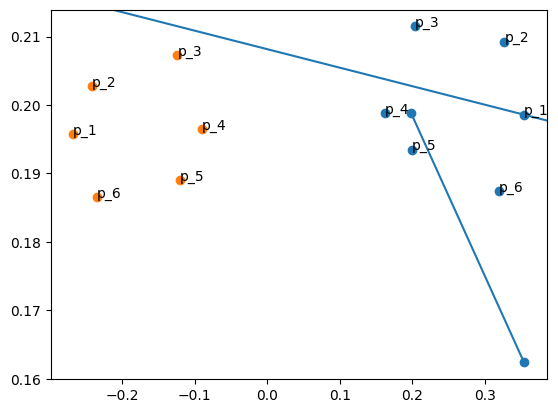

In [52]:
# import pickle
# with open("Reference.pickle", "rb") as file:
#     ref_face = pickle.load(file)
    
shape_feature = face.create_shape_feature(demo=True)
print(shape_feature.shape)
# shape feature is 49 length with no intercept crop

fig = plt.figure()
ax = fig.add_subplot(111)
x_points, y_points = face.key_points.left_eye[[8, 6, 2, 0, 14, 10], 0], face.key_points.left_eye[[8, 6, 2, 0, 14, 10], 1]
plt.scatter(x_points, y_points,)
x_points_right, y_points_right = face.key_points.right_eye[[8, 6, 2, 0, 14, 10], 0], face.key_points.right_eye[[8, 6, 2, 0, 14, 10], 1]
plt.scatter(x_points_right, y_points_right,)

# print()
plt.axline(face.key_points.left_eye[8, :2], face.key_points.left_eye[1, :2])
plt.plot(face.key_points.left_eye[8, :2], face.key_points.left_eye[0, :2], marker = 'o')

for idx, xy in enumerate(zip(x_points, y_points)): 
    ax.annotate(f'p_{idx+1}', xy=xy, textcoords='data',) # <--

for idx, xy in enumerate(zip(x_points_right, y_points_right)): 
    ax.annotate(f'p_{idx+1}', xy=xy, textcoords='data',) # <--
    
plt.show()
# aspect_ratio_left = ((np.linalg.norm(self.key_points.left_eye[6, :] - self.key_points.left_eye[10, :]) +
#                               np.linalg.norm(self.key_points.left_eye[3, :] - self.key_points.left_eye[15, :])) /
#                              (2 * np.linalg.norm(self.key_points.left_eye[8, :] - self.key_points.left_eye[0, :])))

In [10]:
delta_feature = face.create_delta_feature(ref_face, demo=True)

NameError: name 'ref_face' is not defined

Bring together all predictors

In [ ]:
# fusion_feature = np.concatenate([net_data.flatten(), shape_feature, blend_data])
fusion_feature = np.concatenate([shape_feature, blend_data, predictions.flatten()])
print(fusion_feature.shape)